## 0.Download Dataset

In [1]:
# https://drive.google.com/file/d/1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM/view
!gdown --id 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
!unzip -q icdar2003.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
From (redirected): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM&confirm=t&uuid=d931153e-314d-45ca-95ac-104ae7d86fde
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 80.6MB/s]


## 1.Import libraries

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [3]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## 2. Extract Data from XML and Store in New Folder

### Extract

In [4]:
def extract_data_from_xml(root_dir):
    """
    Trích xuất dữ liệu từ file words.xml trong bộ IC03

    Hàm này dùng để trích các thông tin từ file .xml bao gồm:
    image paths, image sizes, image labels và bboxes

    Parameters:
        root_dir (str): Đường dẫn đến thư mục root của dataset

    Returns:
        tuple: Chứa 4 lists lần lượt là: image paths, image sizes, image labels, và bboxes.
    """

    # Tạo path đến file words.xml
    xml_path = os.path.join(root_dir, 'words.xml')
    # Parse file xml
    tree = ET.parse(xml_path)
    # Đọc thẻ root của file
    root = tree.getroot()

    # Khai báo các list rỗng để lưu dữ liệu
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    # Duyệt qua từng thẻ ảnh <image>
    for img in root:
        # Khai báo các list rỗng chứa bboxes và labels của ảnh đang xét
        bbs_of_img = []
        labels_of_img = []

        # Duyệt qua từng thẻ boundingbox
        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # Bỏ qua trường hợp label không phải kí tự alphabet hoặc number
                if not bb[0].text.isalnum():
                    continue

                # Bỏ qua trường hợp label là chữ 'é' hoặc ñ'
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                # Đưa thông tin tọa độ bbox vào list bbs_of_img
                # Format bbox: (xmin, ymin, bbox_width, bbox_height)
                bbs_of_img.append(
                    [
                        float(bb.attrib['x']),
                        float(bb.attrib['y']),
                        float(bb.attrib['width']),
                        float(bb.attrib['height'])
                    ]
                )
                # Đưa label vào list labels_of_img (đã chuyển chữ viết thường)
                labels_of_img.append(bb[0].text.lower())

        # Đưa thông tin path ảnh đang xét vào list img_paths
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        # Đưa thông tin độ phân giải ảnh vào list img_sizes
        img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
        # Đưa list bbox vào list bboxes
        bboxes.append(bbs_of_img)
        # Đưa list labels vào list img_labels
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [5]:
# Thực hiện lời gọi hàm extract_data_from_xml()
dataset_dir = 'SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

In [6]:
print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 250
Total bounding boxes: 1097


### Plot an example

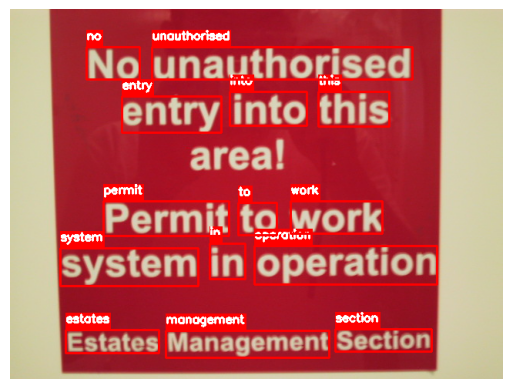

In [7]:
def plot_image_with_bbs(img_path, bbs, labels):
    """
    Trực quan hóa bounding box với label lên ảnh.

    Parameters:
        img_path (str): Đường dẫn đến ảnh.
        bbs (list): Danh sách các bounding box.
        labels (list): Danh sách các label.
    """
    # Đọc ảnh
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Duyệt qua từng bounding box
    for idx, bb in enumerate(bbs):
        # Vẽ bounding box lên ảnh
        start_point = (int(bb[0]), int(bb[1]))
        end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
        color = (255, 0, 0)
        thickness = 2
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        # Vẽ label lên cạnh bounding box
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)
        line_type = 2
        text_thickness = 2
        label = labels[idx]
        text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)


        label_background_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
        label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
        img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)


        cv2.putText(
            img,
            label,
            (int(bb[0]), int(bb[1] - 10)),
            font,
            font_scale,
            font_color,
            text_thickness,
            line_type
        )

    # Show ảnh
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Random chỉ mục của một ảnh bất kỳ để visualize
i = random.randint(0, len(img_paths))
plot_image_with_bbs(img_paths[i], bboxes[i], img_labels[i])

### Store all bounding boxes as a new dataset

In [8]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    """
    Xây dựng thư mục chứa dữ liệu cho Text Recognition.

    Hàm sẽ tạo một thư mục save_dir, lưu các ảnh cắt từ tọa độ bbox.
    Label sẽ được lưu riêng vào file labels.txt.

    Parameters:
        img_paths (list): Danh sách các path ảnh.
        img_labels (list): Danh sách chứa danh sách labels của các ảnh.
        bboxes (list): Danh sách chứa danh sách bounding box của các ảnh.
        save_dir (str): Đường dẫn đến thư mục chứa dữ liệu.
    """
    # Tạo tự động thư mục chứa dữ liệu
    os.makedirs(save_dir, exist_ok=True)

    # Khai báo biến đếm và danh sách rỗng chứa labels
    count = 0
    labels = []

    # Duyệt qua từng cặp (đường dẫn ảnh, list label, list bbox)
    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        # Đọc ảnh
        img = Image.open(img_path)

        # Duyệt qua từng cặp label và bbox
        for label, bb in zip(img_label, bbs):
            # Cắt ảnh theo bbox
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # Bỏ qua trường hợp 90% nội dung ảnh cắt là màu trắng hoặc đen.
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            # Bỏ qua trường hợp ảnh cắt có width < 10 hoặc heigh < 10
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            # Bỏ qua trường hợp số kí tự của label < 3
            if len(label) < 3:
                continue

            # Tạo tên cho file ảnh đã cắt và lưu vào save_dir
            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            # Đưa format label mới vào list labels
            # Format: img_path\tlabel
            label = new_img_path + '\t' + label

            labels.append(label)  # Append label to the list

            count += 1

    print(f"Created {count} images")

    # Đưa list labels vào file labels.txt
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(f"{label}\n")

In [9]:
# Thực hiện lời gọi hàm split_bounding_boxes()
save_dir = 'datasets/ocr_dataset'
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 928 images


## 3. Read dataset

In [10]:
# Đọc dữ liệu từ thư mục đã tạo
root_dir = save_dir

img_paths = []
labels = []

with open(os.path.join(root_dir, 'labels.txt'), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(img_paths)}")

Total images: 928


## 4. Prepare vocabulary

In [11]:
# Lấy tất cả các kí tự trong danh sách labels
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
# Lọc kí tự trùng
letters = sorted(list(set(list(letters))))

# Chuyển list kí tự thành string
chars = "".join(letters)

# Thêm kí tự "blank" vào bộ vocab
blank_char = '-'
chars += blank_char
# Tính vocab size
vocab_size = len(chars)

print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [12]:
# Tạo dictionary chuyển đổi kí tự (class) sang dạng số và ngược lại
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [13]:
# Tìm label có độ dài lớn nhất
# Đặt làm max_label_len để padding
max_label_len = max([len(label) for label in labels])

In [14]:
def encode(label, char_to_idx, max_label_len):
    """
    Encode label thành tensor

    Paramaters:
        label (str): String label.
        char_to_idx (dict): Bảng mapping classname -> ID.
        max_label_len (int): Độ dài tối đa cho label.

    Returns:
        padded_labels (tensor): Tensor label đã được encode và padding.
        lengths (tensor): Độ dài trước khi padding của label.
    """
    # Đổi sang tensor
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.long
    )
    # Tính len của label
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.long
    )
    # Padding
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return padded_labels, lengths

In [15]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    """
    Decode encoded label thành string

    Parameters:
        encoded_sequences (list): Danh sách các tensor label.
        idx_to_char (dict): Bảng mapping ID -> classname.
        blank_char (str): Kí tự "blank".

    Returns:
        decoded_sequences (list): danh sách các label đã được decode.
    """
    # Khai báo list rỗng chứa kết quả decode
    decoded_sequences = []

    # Duyệt qua từng encoded label
    for seq in encoded_sequences:
        # Khai báo list rỗng chứa từng kí tự đã decode
        decoded_label = []
        # Duyệt qua từng token
        for idx, token in enumerate(seq):
            # Bỏ qua token padding (ID=0)
            if token != 0:
                # Lấy kí tự của token đang xét trong idx_to_char
                char = idx_to_char[token.item()]
                # Bỏ qua kí tự "blank"
                if char != blank_char:
                    decoded_label.append(char)
        # Thêm chuỗi đã decode vào list decoded_sequences
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

## 5. Create data preprocessing function

In [16]:
# Khai báo hàm transform dữ liệu
data_transforms = {
    # Dành cho dữ liệu train
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5
        ),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=2, shear=2),
        transforms.RandomPerspective(
            distortion_scale=0.4,
            p=0.5,
            interpolation=3
        ),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    # Dành cho dữ liệu val, test
    'val': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
}

In [17]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## 7. Create pytorch dataset

In [18]:
class STRDataset(Dataset):
    def __init__(
        self,
        X, y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label,
                self.char_to_idx,
                self.max_label_len
            )
        return img, encoded_label, label_len

## 8. Create dataloader

In [19]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

In [20]:
print(f"Train dataset: {len(train_dataset)}", f"Val dataset: {len(val_dataset)}", f"Test dataset: {len(test_dataset)}", sep='\n')

Train dataset: 649
Val dataset: 186
Test dataset: 93


In [21]:
train_batch_size = 32
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

['mouth', 'heart', 'health', 'but', 'isuzu', 'sound', 'objects', 'intelligence', 'careers', 'arms', 'are', 'the', 'hotel', 'essence', 'modern', 'final', 'hire', 'report', 'county', 'serious', 'computing', 'united', 'learning', 'wrox', 'warning', 'conviction', 'please', 'colchester', 'authorised', 'fisio', 'zanussi', 'spirits']


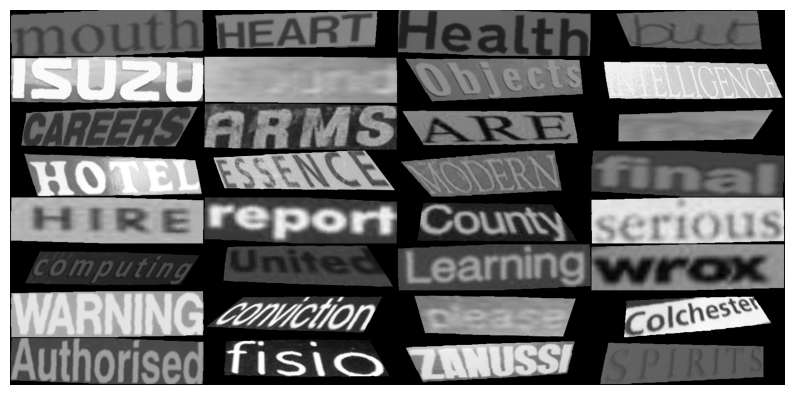

In [22]:
train_features, train_labels, train_lengths = next(iter(train_loader))

# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    print(labels)
    plt.show()

show_batch(train_features, train_labels)

## 9. Create model

In [23]:
class CRNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2,
        unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        # Khởi tạo pretrained model resnet101
        backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True
        )
        # Bỏ đi lớp classifer gốc của pretrained
        modules = list(backbone.children())[:-2]
        # Thêm vào lớp AdaptiveAvgPool2d
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Mở băng (unfreeze) một số layers cuối cùng của pretrained model
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        # Layer dùng để map từ CNN features maps sang LSTM
        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(
            1024, hidden_size,
            n_layers, bidirectional=True, batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x) # shape: (bs, c, h, w)
        x = x.permute(0, 3, 1, 2) # shape: (bs, w, c, h)
        x = x.view(x.size(0), x.size(1), -1)  # Remove h: (bs, w, c)
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x) # shape: (bs, seq_len, n_classes)
        x = x.permute(1, 0, 2) # Based on CTC # (seq_len, bs, n_classes)

        return x

In [24]:
hidden_size = 256
n_layers = 2
dropout_prob = 0.3
unfreeze_layers=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [25]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([14, 64, 37])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


## 10. Training

In [26]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(
                outputs, labels, logits_lens, labels_len
            )
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [27]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()
            # Thực hiện gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                5
            )
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

        scheduler.step()

    return train_losses, val_losses

In [28]:
epochs = 100
lr = 0.001
weight_decay=1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [29]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 3.8309	Val loss: 3.4408
EPOCH 2:	Train loss: 3.3979	Val loss: 3.5367
EPOCH 3:	Train loss: 3.1479	Val loss: 3.0182
EPOCH 4:	Train loss: 2.8038	Val loss: 2.6095
EPOCH 5:	Train loss: 2.2344	Val loss: 2.0469
EPOCH 6:	Train loss: 1.6564	Val loss: 1.6529
EPOCH 7:	Train loss: 1.2081	Val loss: 1.3368
EPOCH 8:	Train loss: 0.9036	Val loss: 0.9393
EPOCH 9:	Train loss: 0.7650	Val loss: 0.9086
EPOCH 10:	Train loss: 0.6365	Val loss: 0.7840
EPOCH 11:	Train loss: 0.5417	Val loss: 0.7731
EPOCH 12:	Train loss: 0.5118	Val loss: 0.7729
EPOCH 13:	Train loss: 0.5292	Val loss: 0.6785
EPOCH 14:	Train loss: 0.4062	Val loss: 0.7009
EPOCH 15:	Train loss: 0.3449	Val loss: 0.7316
EPOCH 16:	Train loss: 0.3744	Val loss: 0.7553
EPOCH 17:	Train loss: 0.3490	Val loss: 0.7111
EPOCH 18:	Train loss: 0.3625	Val loss: 0.6711
EPOCH 19:	Train loss: 0.2986	Val loss: 0.6603
EPOCH 20:	Train loss: 0.2660	Val loss: 0.6733
EPOCH 21:	Train loss: 0.2753	Val loss: 0.6419
EPOCH 22:	Train loss: 0.2534	Val loss: 0.67

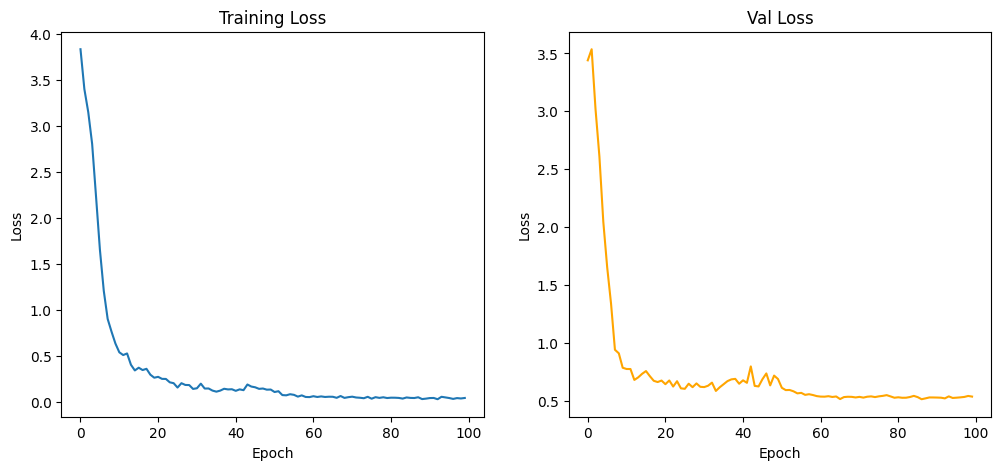

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 11. Evaluation

In [31]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  0.5346578106594583
Test loss:  0.4780389272297422


## 12. Make Predictions

In [32]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

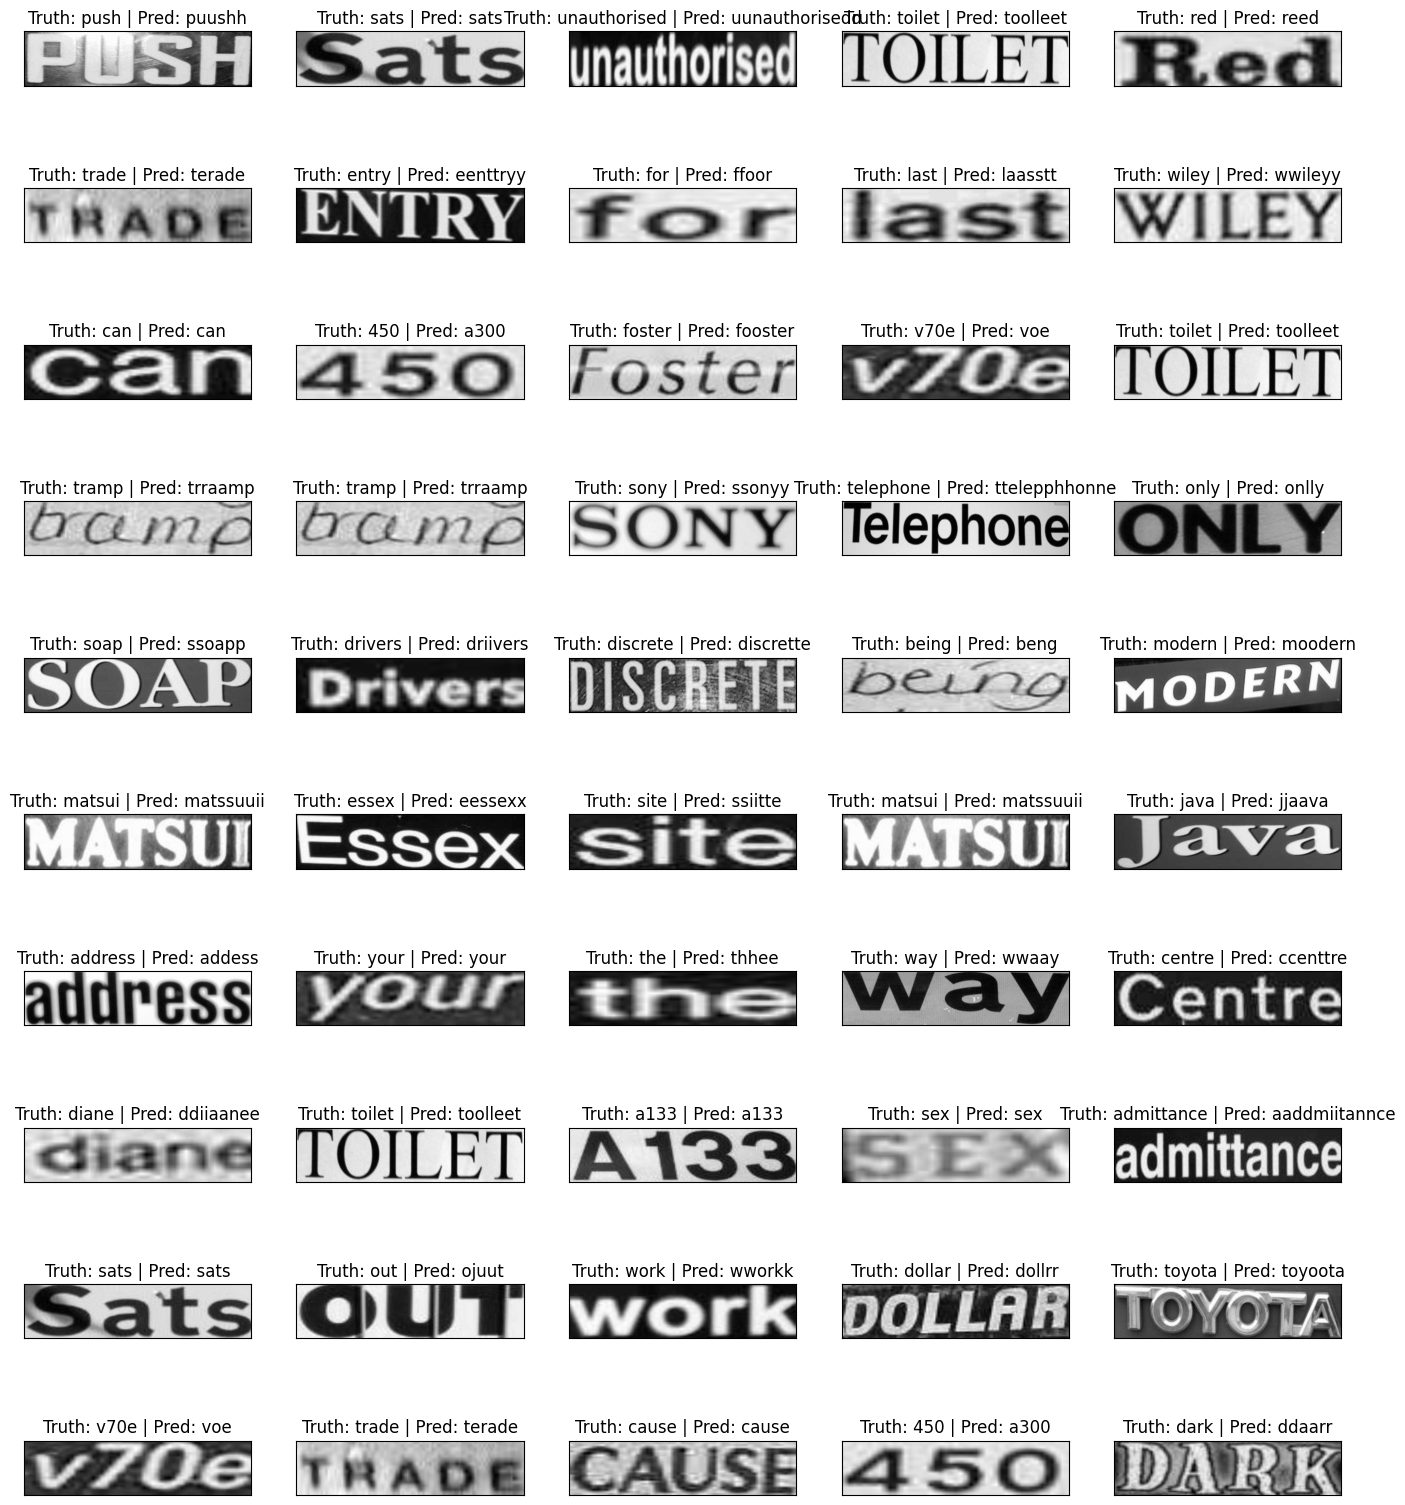

In [33]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = val_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

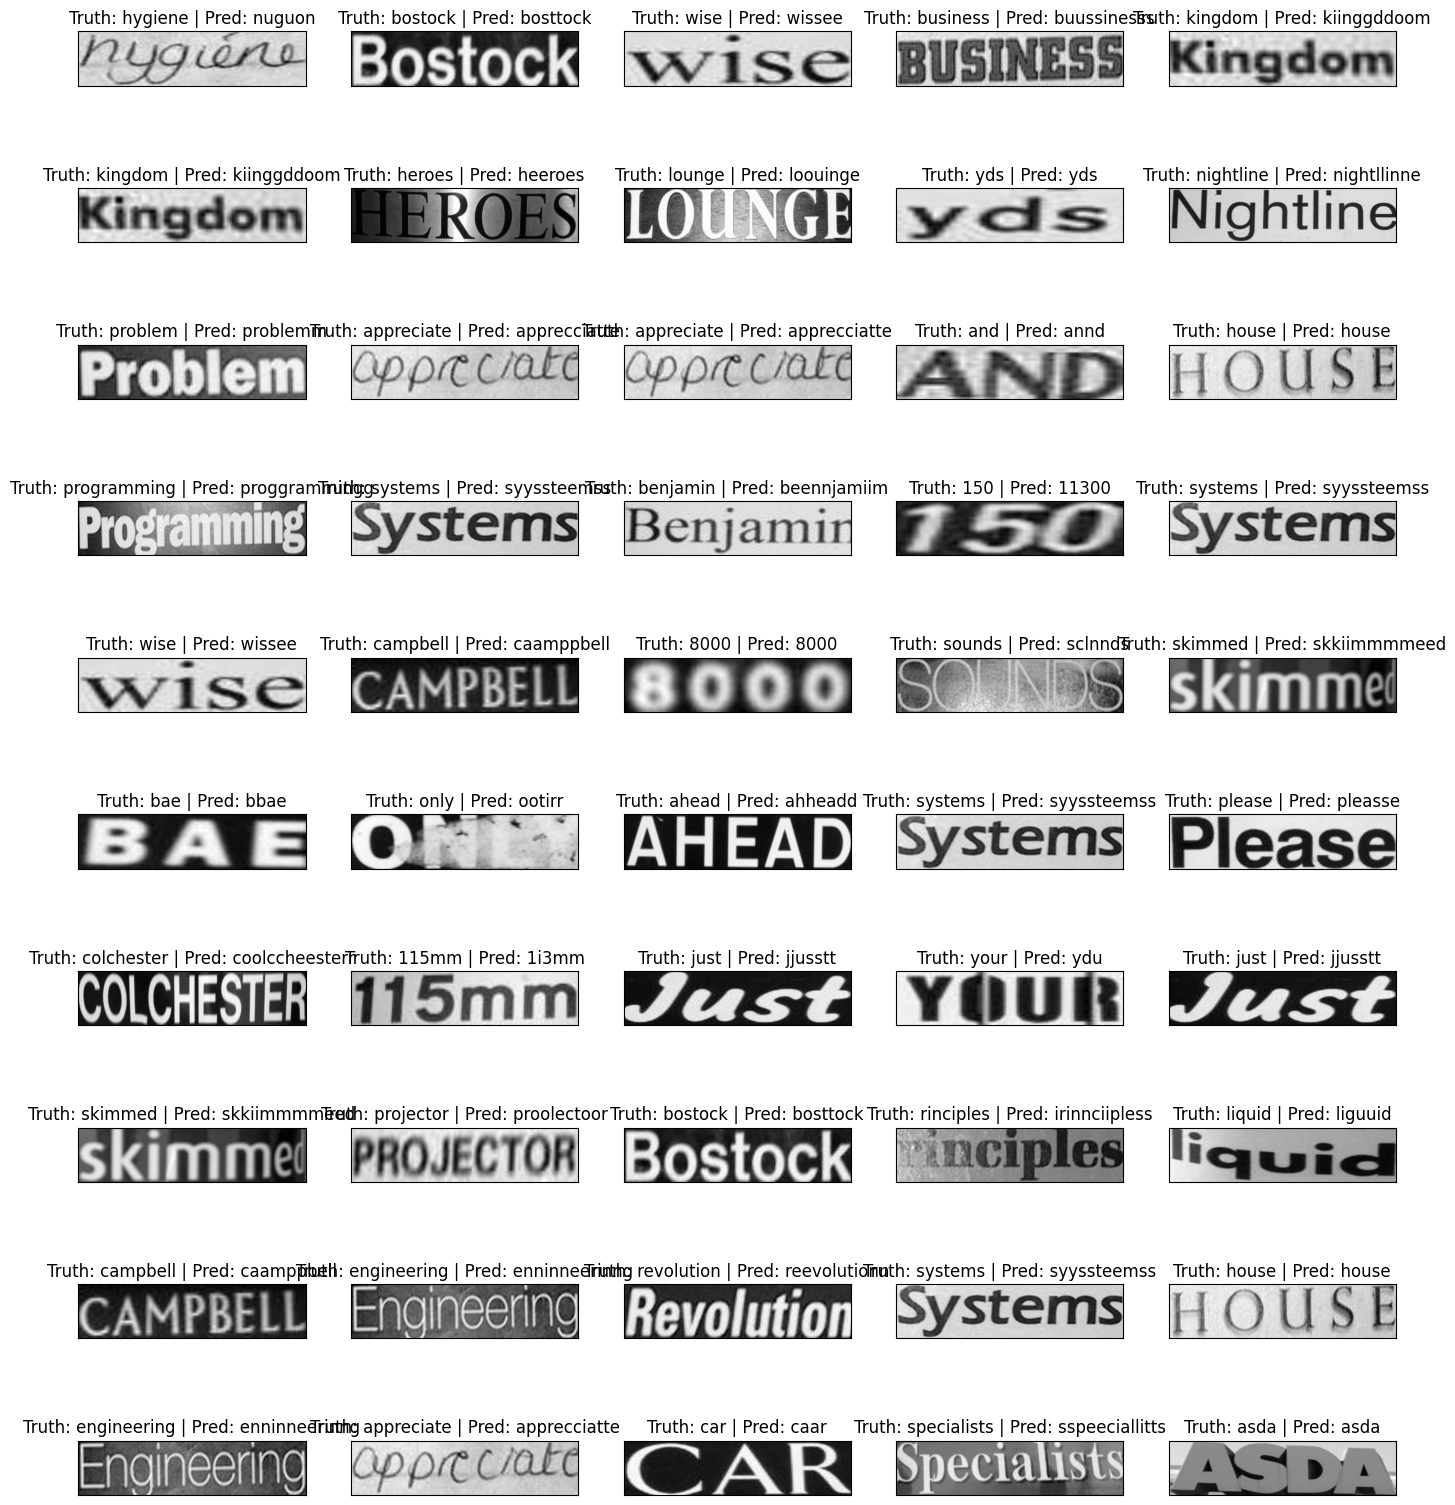

In [34]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = test_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

In [37]:
save_model_path = 'models/ocr_crnn_resnet_best.pt'
torch.save(
    model.state_dict(),
    save_model_path
)